<a href="https://colab.research.google.com/github/crazyboyonline/-/blob/main/Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==0.14

     |████████████████████████████████| 48 kB 2.7 MB/s 


In [ ]:
!pip install mxnet==1.7.0.post1

     |████████████████████████████████| 55.0 MB 1.3 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import os
import pandas as pd
from mxnet import gluon, np
from d2l import mxnet as d2l

In [ ]:
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

def read_data_ml100k():
  data_dir = d2l.download_extract('ml-100k')
  names = ['user_id','item_id','rating','timestamp']
  data = pd.read_csv(os.path.join(data_dir,'u.data'),'\t',names = names,engine = 'python')
  num_users = data.user_id.unique().shape[0]
  num_items = data.item_id.unique().shape[0]
  return data, num_users,num_items

In [ ]:
data, num_users, num_items, = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  """Entry point for launching an IPython kernel.


number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


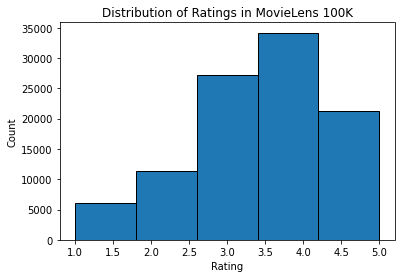

In [ ]:
d2l.plt.hist(data['rating'], bins = 5 , ec = 'black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

In [ ]:
def split_data_ml100k(data, num_users, num_items,split_mode='random', test_ratio=0.1): 
  if split_mode == 'seq-aware':
    train_items, test_items, train_list = {},{},[]
    for line in data.itertuples():
      u,i ,rating, time = line[1],line[2],line[3],line[4]
      train_items.setdefault(u,[]).append((u,i,rating,time))
      if u not in test_items or test_items[u][-1]< time:
        test_items[u] = (i, rating,time)
    for u in range(1,num_users + 1):
      train_list.extend(sorted(train-items[u], key= lambda k : k[3]))
    test_data = [(key,*value) for key, value in test_items.items()]
    train_data=[item for item in train_list if item not in test_data]
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
  else:
    mask = [Trur if x == 1 else False for x in np.random.uniform(0,1,(len(data))) < 1 - test_ratio]
    neg_mask = [ not x for x in mask]
    train_data, test_data = data[mask], data[neg_mask]
  return train_data, test_data

数据集拆分后，为了方便起见，我们会将训练集和测试集转换为列表和字典/矩阵。以下函数逐行读取数据帧并从零开始枚举用户/项目的索引。然后该函数返回用户、项目、评级和记录交互的字典/矩阵的列表。我们可以将反馈类型指定为explicit 或implicit。



In [ ]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

之后，我们将上述步骤放在一起，将在下一节中使用。结果用Dataset和 包裹DataLoader。请注意，训练数据的last_batchofDataLoader设置为rollover模式（剩余样本滚动到下一个 epoch。）并且订单被打乱

In [ ]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = gluon.data.ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = gluon.data.DataLoader(
        train_set, shuffle=True, last_batch='rollover',
        batch_size=batch_size)
    test_iter = gluon.data.DataLoader(
        test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

In [ ]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

#模型实现
首先，我们实现上述矩阵分解模型。可以使用nn.Embedding. input_dim是项目/用户的数量， ( )output_dim是潜在因素的维度 ( k ）。我们还可以 nn.Embedding通过将 设置为 1 来创建用户/项目偏差 output_dim。在该forward函数中，用户和项目 ID 用于查找嵌入。

In [ ]:
class MF(nn.Block):
  def __init__(self, num_factors, num_users,num_items,**kwargs):
      super(MF,self).__init__(**kwargs)
      self.P = nn.Embedding(input_dim = num_users,output_dim = num_factors)
      self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
      self.user_bias = nn.Embedding(num_users,1)
      self.item_bias = nn.Embedding(num_items,1)

  def forward(self, user_id, item_id):
    P_u = self.P(user_id)
    Q_i = self.Q(item_id)
    b_u = self.user_bias(user_id)
    b_i = self.item_bias(item_id)
    outputs = (P_u *Q_i).sum(axis = 1) + np.squeeze(b_u) + np.squeeze(b_i)
    return outputs.flatten()

#评价措施

In [ ]:
def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

#训练和评估模型

In [ ]:
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

train loss 0.064, test RMSE 1.037
102717.0 examples/sec on [cpu(0)]


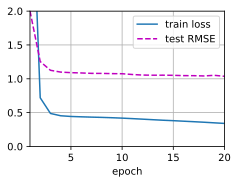

In [ ]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
net = MF(30, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

下面，我们使用经过训练的模型来预测用户 (ID 20) 可能给项目 (ID 30) 的评分。



In [ ]:
scores = net(np.array([20], dtype='int', ctx=devices[0]),
             np.array([30], dtype='int', ctx=devices[0]))
scores

array([3.1123998])